<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(bim_manual.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### BASIC ITERATIVE METHOD   (BIM)
https://www.neuralception.com/adversarialexamples-bim/  

### Lab Objectives:  
- Learn about the Basic Iterative Method (BIM)
- Implement BIM from scratch   
- Visualize the real input, the perturbations and the adversarial example 

### Step 1: 

In [1]:
# import libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Numpy version used:  {np.__version__}')

Torch version used:  2.7.1+cu128
Numpy version used:  2.1.3


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [4]:
# I am going to cheat here. 
# I seem to be running into a problem with my GPU and backpropagation. 
# So to address that, I am forcing this to use CPU.
# You can test on your system by commenting out this line below and running the code
# However, without the GPU this works just fine!
# Honestly, I lost interest in troubleshooting the issue
# Maybe I will revisit it later
device = 'cpu'

In [5]:
# Load the model to be used
#bim_attack_loaded_model = torch.jit.load(f=r'/tmp/malware_classifier.jit.pth')
bim_attack_loaded_model = torch.jit.load(f=r'../data/bodmas_malware_classifier.jit', map_location=device)
bim_attack_loaded_model.eval()

RecursiveScriptModule(
  original_name=MalwareClassifier
  (layers): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=BatchNorm1d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Dropout)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=BatchNorm1d)
    (6): RecursiveScriptModule(original_name=ReLU)
    (7): RecursiveScriptModule(original_name=Dropout)
    (8): RecursiveScriptModule(original_name=Linear)
    (9): RecursiveScriptModule(original_name=BatchNorm1d)
    (10): RecursiveScriptModule(original_name=ReLU)
    (11): RecursiveScriptModule(original_name=Dropout)
    (12): RecursiveScriptModule(original_name=Linear)
  )
)

With out model loaded, we need to get our data. Let us load the test data we saved from the **bodmas_malware_classifier.ipynb** lab. 

### Step 2:  

In [6]:
# Load the test data
X_test = np.load(file='../data/bodmas_test_pca_scaled.npz')
X_test, y_test = X_test['X'], X_test['y']

X_test.shape, y_test.shape

((26887, 1024), (26887, 1))

To ensure we only focus on flipping the malware labels 1 to benign 0, we will extract all the malware samples and focus only on those. This ensures we keep our attack simple enough to be able to understand the issue.

When we index into y_test to extract all the malware via:   
  (y_test == 1) 

out output now looks like: 
array([[ True],   
       [False],   
       [ True],   
       ...,    
       [False],   
       [ True],   
       [ True]])   

We will not be able to index into here so we squeeze out the batch dimension to make this into a vector.   (y_test == 1).squeeze()    

With this we can now index into X_test  
X_test[(y_test == 1).squeeze()]  


In [7]:
# Index into y_test and extract all the index positions where we have 1
# use that as input to pull the correspond rows in X_test
malware_samples = X_test[(y_test == 1).squeeze()]

# Convert to torch tensor
malware_samples = torch.tensor(data=malware_samples, device=device)
malware_samples[:5], malware_samples.size()

(tensor([[  9.7490,  12.0801,   2.6129,  ...,   0.0452,   0.0400,  -0.0575],
         [ -4.2943,  -3.1780,  -2.9593,  ...,   0.6389,   0.4274,   0.5765],
         [ -9.8720,   5.7994,  -8.6096,  ...,  -0.2566,   0.1027,  -0.2765],
         [  7.9377,  10.6579,   1.8678,  ...,   0.0235,  -0.0347,   0.1870],
         [-12.2579,   1.8096,  -6.1364,  ...,   0.2999,   0.1371,   0.3495]]),
 torch.Size([11394, 1024]))

In [8]:
# Get the known malware labels
malware_labels = y_test[y_test == 1].reshape(-1,1)
malware_labels = torch.tensor(malware_labels, device=device)
malware_labels[:5]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

Time to test our loaded model on our data  

### Step 3:

In [9]:
# Test the model to ensure it works on our data
bim_attack_loaded_model(malware_samples)

tensor([[18.5160],
        [20.6547],
        [16.4855],
        ...,
        [15.0573],
        [17.0050],
        [16.3175]], grad_fn=<AddmmBackward0>)

The results above represents the raw logits from the network. If we wish to have probabilities, we will have to use the Sigmoid activation function on this data.  

Let's us write our function to perform the BIM attack

### Step 4:

In [10]:
# This attack can be targeted or untargeted 
# https://adversarial-attacks-pytorch.readthedocs.io/en/latest/_modules/torchattacks/attacks/bim.html
# https://github.com/peyman-paknezhad/Adversarial-Robustness-in-Neural-Networks-Implementation-and-Assessment-of-FGSM-BIM-and-PGD-Attacks/blob/main/Adversarial_Robustness_in_Neural_Networks_Implementation_and_Assessment_of_FGSM%2C_BIM%2C_and_PGD_Attacks.ipynb
# https://locuslab.github.io/2019-03-12-provable/
# https://arxiv.org/pdf/1607.02533

def basic_iterative_method(model=None, X=None, label=None, eps=None, alpha=None, n_iterations=1):
    
    # Just moving the model to the device
    model = model.to(device)

    # Create a copy of the original input
    adversarial_X = X.clone().detach()

    for iteration in range(n_iterations):
        #print('Iterating ...')

        # Zero out the gradients so they do not accumulate
        model.zero_grad(set_to_none=True)

        # Set the adversarial X to require gradient
        adversarial_X.requires_grad_(True)

        # Get the logits
        adversarial_logits = model(adversarial_X)

        #label = label.to(adversarial_logits.device).float()
        #if adversarial_logits.shape != label.shape:
        #    print(f'Shape mismatch')
        #    label = label.view_as(adversarial_logits)

        # Calculate the loss
        loss = F.binary_cross_entropy_with_logits(input=adversarial_logits, target=label)
        
        # Get the gradients with respect to the input (adversarial_X)
        # just another way of using torch autograd
        gradients = torch.autograd.grad(outputs=loss, inputs=adversarial_X, retain_graph=False, create_graph=True)[0]

        # Setup the adversarial example
        # Step in the direction of the gradients
        # Note we are taking the sign of the gradients
        adversarial_X = adversarial_X + alpha * gradients.sign()

        # Create the perturbations by clipping the current adversarial values 
        # to a range between the minimum and maxim of the eps value
        perturbation = torch.clamp(input=adversarial_X - X, min=-eps, max=eps)

        # Add the perturbation to the original X input 
        # and clamp the values between 0 and 1
        adversarial_X = torch.clamp(input=X + perturbation, min=0, max=1).detach_()

        print(f'Iteration: {iteration+1} / {n_iterations} \t loss: {loss.item()}')

    # Return the perturbations and the adversarial example(s)
    return perturbation.detach(), adversarial_X

In [11]:
# Test the function 
perturbations, adversarial_x = basic_iterative_method(model=bim_attack_loaded_model, X=malware_samples, label=malware_labels, eps=0.2, alpha=0.1, n_iterations=5)

Iteration: 1 / 5 	 loss: 0.027127373963594437
Iteration: 2 / 5 	 loss: 2.9356870651245117
Iteration: 3 / 5 	 loss: 10.540270805358887
Iteration: 4 / 5 	 loss: 15.015287399291992
Iteration: 5 / 5 	 loss: 16.396024703979492


Visualize the results now that we have run our function

### Step 5: 

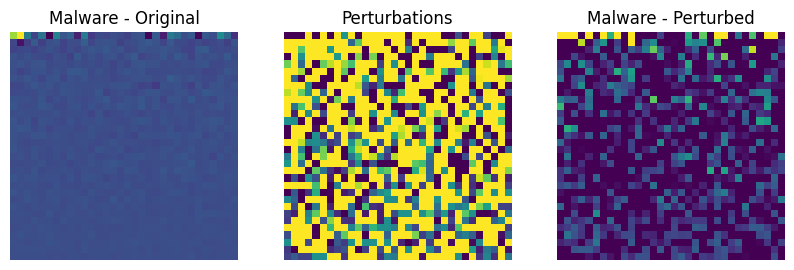

In [12]:
# Visualizing the results  
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
ax.set_title(label='Malware - Original')
ax.imshow(malware_samples[:1].view(32,32))
ax.axis('off')

ax = fig.add_subplot(132)
ax.set_title(label='Perturbations')
ax.imshow(perturbations[:1].view(32,32))
ax.axis('off')

ax = fig.add_subplot(133)
ax.set_title(label='Malware - Perturbed')
ax.imshow(adversarial_x[:1].view(32,32))
ax.axis('off')

plt.show()

Working with the real model and the adversarial_x which was generated  
 
### Step 6:  

In [13]:
# Make the prediction on the original sample
# bim_attack_loaded_model(malware_samples[:1])

In [14]:
# Model make the prediction on the BIM results
adversarial_logits = bim_attack_loaded_model(adversarial_x)
adversarial_logits

tensor([[-21.4735],
        [ -3.6235],
        [-20.5143],
        ...,
        [-19.4477],
        [ -9.4225],
        [-16.4370]], grad_fn=<DifferentiableGraphBackward>)

In [15]:
# Pass the logits through sigmoid to get the probabilities 
adversarial_probs = F.sigmoid(input=adversarial_logits)
adversarial_probs

tensor([[4.7226e-10],
        [2.5995e-02],
        [1.2324e-09],
        ...,
        [3.5806e-09],
        [8.0880e-05],
        [7.2694e-08]], grad_fn=<SigmoidBackward0>)

In [16]:
# Make the final class prediction by rounding the probabilities
(adversarial_probs).round()

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [17]:
# Get model accuracy on the known malware set
torch.manual_seed(10)
real_predictions = F.sigmoid(bim_attack_loaded_model(malware_samples)).round()
accuracy = (malware_labels == real_predictions).sum() / malware_labels.size(dim=0)
print(f'Accuracy on the real malware is: {accuracy:.2f}')

Accuracy on the real malware is: 0.99


When we pass the real samples through the FGSM attack, we have 99% accuracy. That is good.  
Let us run this again to generate our adversarial examples    

### Step 7:  

In [18]:
# Against the adversarial examples
torch.manual_seed(10)
perturbations, adversarial_examples = basic_iterative_method(model=bim_attack_loaded_model, eps=0.02, alpha=0.01, X=malware_samples, label=malware_labels, n_iterations=10)

Iteration: 1 / 10 	 loss: 0.027127373963594437
Iteration: 2 / 10 	 loss: 0.44904059171676636
Iteration: 3 / 10 	 loss: 0.7097464799880981
Iteration: 4 / 10 	 loss: 0.8787121772766113
Iteration: 5 / 10 	 loss: 0.9049869775772095
Iteration: 6 / 10 	 loss: 0.9102219939231873
Iteration: 7 / 10 	 loss: 0.9122626781463623
Iteration: 8 / 10 	 loss: 0.9134421348571777
Iteration: 9 / 10 	 loss: 0.9136663675308228
Iteration: 10 / 10 	 loss: 0.9137996435165405


We noticed above also that whereas we normally want the loss to decrease, in adversarial AI, we want the loss to increase. This is because we are trying to flip the label. In a targeted attack, we would need to reduce the loss on the particular class.  

In [19]:
# Make predictions on the adversarial examples
torch.manual_seed(10)
perturb_predictions = F.sigmoid(bim_attack_loaded_model(adversarial_examples)).round()

# View the first 5
perturb_predictions[:5]

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.]], grad_fn=<SliceBackward0>)

In [20]:
# Get the accuracy on the adversarial examples
torch.manual_seed(10)

accuracy = (malware_labels == perturb_predictions).sum() / perturb_predictions.size(dim=0)
print(f'Accuracy on the real malware is: {accuracy:.2f}')
print(f'Adversarial success rate: {1 - accuracy:.2f}')

Accuracy on the real malware is: 0.66
Adversarial success rate: 0.34


After 10 epochs, we were, we have already started to influence the model as we have a higher success rate on the adversarial attacks.

We can change our EPS value like we did for Fast Gradient Descent to even increase the success rate. 

In [21]:
# With the training finish clear the GPU cache
# Setup the device to work with
if torch.cuda.is_available():
    # For CUDA GPU
    print(f'Cleaning {device} cache')
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    # For Apple devices
    print(f'Cleaning {device} cache')
    torch.mps.empty_cache()
else:
    # Default to cpu
    pass

Cleaning cpu cache


### Lab Takeaways:  
- We loaded a pre-trained model   
- We got some test data  
- We built our own Basic Iterative Method (BIM) attack from scratch 